In [0]:
import keras
from keras_preprocessing import text
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding, Input, Conv1D, MaxPooling1D, LSTM, Dropout
from keras import backend as K
import keras.initializers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import os
import zipfile
import csv,io
import nltk
import string
from string import punctuation
import re
from sklearn.preprocessing import LabelBinarizer

Using TensorFlow backend.


In [0]:
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Constants

EMBED_SIZE=300
VOCAB_SIZE = 10000
INDEX_FROM = 2
#MAXIMUM_LENGTH = 500
TRAIN_SPLIT = 0.8

In [0]:
# Get Data

!wget http://alt.qcri.org/semeval2017/task4/data/uploads/codalab/4a-english.zip

--2019-02-20 02:08:46--  http://alt.qcri.org/semeval2017/task4/data/uploads/codalab/4a-english.zip
Resolving alt.qcri.org (alt.qcri.org)... 13.93.27.76
Connecting to alt.qcri.org (alt.qcri.org)|13.93.27.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1670639 (1.6M) [application/zip]
Saving to: ‘4a-english.zip.1’

4a-english.zip.1    100%[===================>]   1.59M  2.57MB/s    in 0.6s    

2019-02-20 02:08:47 (2.57 MB/s) - ‘4a-english.zip.1’ saved [1670639/1670639]



In [0]:
# Extract Training Data File

def extract_without_folder(arc_name, full_item_name, folder):
    with zipfile.ZipFile(arc_name) as zf:
        file_data = zf.read(full_item_name)
    with open(os.path.join(folder, os.path.basename(full_item_name)), "wb") as fout:
        fout.write(file_data)

path_to_zip_file = '4a-english.zip'
directory_to_extract_to = os.getcwd()  
extract_without_folder(path_to_zip_file,'4A-English/SemEval2017-task4-dev.subtask-A.english.INPUT.txt',directory_to_extract_to )

In [0]:
#Sanity Check: Read and Display data
text_file = open("SemEval2017-task4-dev.subtask-A.english.INPUT.txt", "r")
corpus = text_file.read()
print(len(corpus))
print(corpus[:1000])

2995085
619950566786113536	neutral	"Picturehouse's, Pink Floyd's, 'Roger Waters: The Walll - opening 29 Sept is now making waves. Watch the trailer on Rolling Stone - look..."	
619969366986235905	neutral	Order Go Set a Watchman in store or through our website before Tuesday and get it half price! #GSAW @GSAWatchmanBook https://t.co/KET6EGD1an	
619971047195045888	negative	"If these runway renovations at the airport prevent me from seeing Taylor Swift on Monday, Bad Blood will have a new meaning."	
619974445185302528	neutral	"If you could ask an onstage interview question at Miss USA tomorrow, what would it be?"	
619987808317407232	positive	A portion of book sales from our Harper Lee/Go Set a Watchman release party on Mon. 7/13 will support @CAP_Tulsa and the great work they do.	
619994586182619136	positive	"Excited to read ""Go Set a Watchman"" on Tuesday.  But can it possibly live up to ""To Kill a Mockingbird?""  Any opinions?"	
619998879447162881	positive	"Watching Miss USA tomorrow 

In [0]:
#Preprocessing 1 - Create tweet data and labels

labels = []
tweets = []
f = csv.reader(io.StringIO(corpus), delimiter='\t')
for row in f:
  labels.append(row[1])
  tweets.append(row[2])
    #print(row[1], row[2])

In [0]:
remove_terms = punctuation + '0123456789'

In [0]:
def normalize_document(doc):
    stop_words = nltk.corpus.stopwords.words('english')
    wpt = nltk.WordPunctTokenizer()


    # lower case and remove special characters\whitespaces

    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)

    doc = doc.lower()

    doc = doc.strip()

    # tokenize document

    tokens = wpt.tokenize(doc)

    # filter stopwords out of document

    filtered_tokens = [token for token in tokens if token not in stop_words]

    # re-create document from filtered tokens

    doc = ' '.join(filtered_tokens)

    return doc
 

In [0]:
normalize_corpus = np.vectorize(normalize_document)
normalized_corpus = [[word.lower() for word in sent if word not in remove_terms] for sent in tweets]

normalized_corpus = [''.join(tok_sent) for tok_sent in normalized_corpus]

#normalized_corpus = filter(None, normalize_corpus(normalized_corpus))
#normalized_corpus = list(normalized_corpus)
#normalized_corpus = [tok_sent for tok_sent in normalized_corpus if len(tok_sent.split()) > 2]

normalized_corpus = list(normalized_corpus)

In [0]:
print(tweets[0])
print(normalized_corpus[0])

Picturehouse's, Pink Floyd's, 'Roger Waters: The Walll - opening 29 Sept is now making waves. Watch the trailer on Rolling Stone - look...
picturehouses pink floyds roger waters the walll  opening  sept is now making waves watch the trailer on rolling stone  look


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(nb_words=VOCAB_SIZE)
tokenizer.fit_on_texts(normalized_corpus)
sequences = tokenizer.texts_to_sequences(normalized_corpus)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 37028 unique tokens.


In [0]:
def lengths(x):
    if isinstance(x,list):
        yield len(x)
        for y in x:
            yield from lengths(y)

MAXIMUM_LENGTH = max([len(x) for x in normalized_corpus])

In [0]:
from keras.utils import to_categorical

data = pad_sequences(sequences, maxlen=MAXIMUM_LENGTH)

#labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
#print('Shape of label tensor:', labels.shape)

Shape of data tensor: (20632, 144)


In [0]:
print(len(tweets))
print(len(labels))
print(len(data))
print(len(sequences))
print(len(normalized_corpus))
print(data[0])

20632
20632
20632
20632
20632
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 1665 3032 7939    1  911  445    9   65  591 6255  122    1 1191
    7  405  422  331]


In [0]:
os.listdir()

['.config',
 'glove.6B.200d.txt',
 'glove.6B.300d.txt',
 'SemEval2017-task4-dev.subtask-A.english.INPUT.txt',
 'SemEval2017-task4-dev.subtask-CE.english.INPUT.txt',
 'skipgram_keras',
 'glove.6B.50d.txt',
 '4a-english.zip',
 'glove.6B.zip',
 'glove.6B.100d.txt',
 '4c-english.zip',
 'sample_data']

In [0]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
#np.random.shuffle(indices)
data = data[indices]
#labels = labels[indices]


In [0]:


nb_validation_samples = int(TRAIN_SPLIT * data.shape[0])

x_val = data[:-nb_validation_samples]
y_val = labels[:-nb_validation_samples]
x_train = data[-nb_validation_samples:]
y_train = labels[-nb_validation_samples:]


print(nb_validation_samples)
print(len(x_train))
print(len(y_train))

print(len(x_val))
print(len(y_val))

16505
16505
16505
4127
4127


In [0]:
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)

In [0]:
# Get Pre-trained Embeddings

!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

--2019-02-20 02:11:29--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.6.166, 104.20.22.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.6.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  24.8MB/s    in 56s     

2019-02-20 02:12:25 (22.7 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [0]:
!pip install patool

    100% |████████████████████████████████| 81kB 4.8MB/s 


In [0]:
import patoolib

path_to_zip_file = 'cc.en.300.vec.gz'
directory_to_extract_to = os.getcwd()  
patoolib.extract_archive(path_to_zip_file,outdir = directory_to_extract_to )

patool: Extracting cc.en.300.vec.gz ...
patool: running /usr/bin/7z e -o/content -- cc.en.300.vec.gz
patool: ... cc.en.300.vec.gz extracted to `/content'.


'/content'

In [0]:
embeddings_index = {}
f = open('cc.en.300.vec')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 2000000 word vectors.


In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAXIMUM_LENGTH,
                            trainable=False)

In [0]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [0]:
# Model with Embedding Layer
model = Sequential()

#We change our first layer in model1 to an Embedding layer
model.add(keras.layers.Embedding(VOCAB_SIZE,16))


#The second layer is to compute average on all word vectors 
model.add(GlobalAveragePooling1DMasked())



#The output vector is piped through a fully-connected layer
model.add(keras.layers.Dense(16, activation=K.relu))



#The last layer is connected with a single output node with the sigmoid activation function
model.add(keras.layers.Dense(3, activation=K.sigmoid))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_mas (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
Total params: 160,323
Trainable params: 160,323
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(x_train,
                    np.array(y_train),
                    epochs=3,
                    batch_size=100,
                    validation_data=(x_val, np.array(y_val)),
                    verbose=1)


Instructions for updating:
Use tf.cast instead.
Train on 16505 samples, validate on 4127 samples
Epoch 1/3
16505/16505 [==============================] - 1s 78us/step - loss: 1.0338 - acc: 0.5057 - val_loss: 1.0029 - val_acc: 0.4650
Epoch 2/3
16505/16505 [==============================] - 1s 58us/step - loss: 1.0002 - acc: 0.5103 - val_loss: 0.9975 - val_acc: 0.4650
Epoch 3/3
16505/16505 [==============================] - 1s 57us/step - loss: 0.9968 - acc: 0.5103 - val_loss: 0.9965 - val_acc: 0.4650


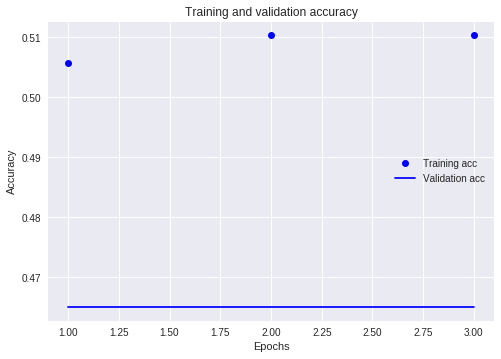

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
#print(x_train[0])
#print(y_train[0])
print(x_val[0])
print(y_val[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  444  451 1982    9   60
  319 1982 5376    2    1   27  172]
[0 1 0]


In [0]:
model_lstm = Sequential() 

model_lstm.add(embedding_layer)

#model_lstm.add(GlobalAveragePooling1DMasked())

model_lstm.add(LSTM(100)) 
model_lstm.add(Dense(3, activation='sigmoid')) 
model_lstm.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) 


In [0]:
print(model_lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 144, 300)          11108700  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 11,269,403
Trainable params: 160,703
Non-trainable params: 11,108,700
_________________________________________________________________
None


In [0]:
history_lstm = model_lstm.fit(x_train,
                    y_train,
                    epochs=3,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 16505 samples, validate on 4127 samples
Epoch 1/3
16505/16505 [==============================] - 91s 5ms/step - loss: 0.9245 - acc: 0.5446 - val_loss: 0.8141 - val_acc: 0.6264
Epoch 2/3
16505/16505 [==============================] - 91s 5ms/step - loss: 0.8416 - acc: 0.5998 - val_loss: 0.7757 - val_acc: 0.6394
Epoch 3/3
16505/16505 [==============================] - 94s 6ms/step - loss: 0.7961 - acc: 0.6248 - val_loss: 0.7856 - val_acc: 0.6261


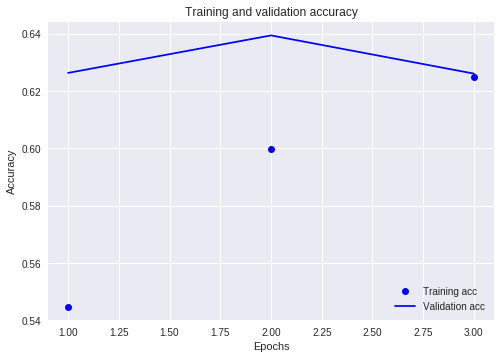

In [0]:
import matplotlib.pyplot as plt

history_dict_lstm = history_lstm.history

acc = history_dict_lstm['acc']
val_acc = history_dict_lstm['val_acc']
loss = history_dict_lstm['loss']
val_loss = history_dict_lstm['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
model_lstm2 = Sequential() 

model_lstm2.add(embedding_layer)
model_lstm2.add(Dropout(0.5))
#model_lstm.add(GlobalAveragePooling1DMasked())

model_lstm2.add(LSTM(100)) 
model_lstm2.add(Dropout(0.5))
model_lstm2.add(Dense(3, activation='sigmoid')) 
model_lstm2.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) 

model_lstm2.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 144, 300)          11108700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 303       
Total params: 11,269,403
Trainable params: 160,703
Non-trainable params: 11,108,700
_________________________________________________________________


In [0]:
history_lstm2 = model_lstm2.fit(x_train,
                    y_train,
                    epochs=3,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 16505 samples, validate on 4127 samples
Epoch 1/3
16505/16505 [==============================] - 97s 6ms/step - loss: 0.9653 - acc: 0.5263 - val_loss: 0.8445 - val_acc: 0.6046
Epoch 2/3
16505/16505 [==============================] - 96s 6ms/step - loss: 0.8893 - acc: 0.5718 - val_loss: 0.8075 - val_acc: 0.6380
Epoch 3/3
16505/16505 [==============================] - 97s 6ms/step - loss: 0.8636 - acc: 0.5854 - val_loss: 0.7980 - val_acc: 0.6487


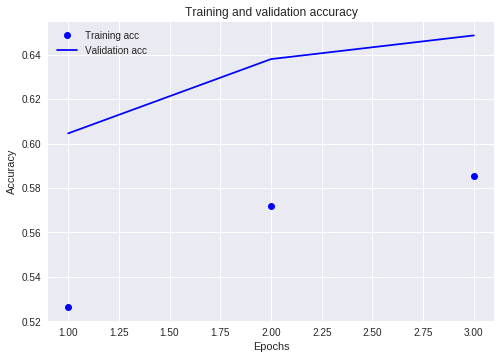

In [0]:
import matplotlib.pyplot as plt

history_dict_lstm2 = history_lstm2.history

acc = history_dict_lstm2['acc']
val_acc = history_dict_lstm2['val_acc']
loss = history_dict_lstm2['loss']
val_loss = history_dict_lstm2['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
from keras import optimizers
ad= optimizers.adam(lr=0.01)

model_lstm3 = Sequential() 

model_lstm3.add(embedding_layer)
model_lstm3.add(Dropout(0.5))
#model_lstm.add(GlobalAveragePooling1DMasked())

model_lstm3.add(LSTM(100)) 
model_lstm3.add(Dropout(0.5))
model_lstm3.add(Dense(3, activation='sigmoid')) 

model_lstm3.compile(loss='categorical_crossentropy',optimizer=ad,  metrics=['accuracy']) 

model_lstm3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 144, 300)          11108700  
_________________________________________________________________
dropout_7 (Dropout)          (None, 144, 300)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 303       
Total params: 11,269,403
Trainable params: 160,703
Non-trainable params: 11,108,700
_________________________________________________________________


In [0]:
history_lstm3 = model_lstm3.fit(x_train,
                    y_train,
                    epochs=3,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 16505 samples, validate on 4127 samples
Epoch 1/3
16505/16505 [==============================] - 96s 6ms/step - loss: 0.9584 - acc: 0.5221 - val_loss: 0.9277 - val_acc: 0.5575
Epoch 2/3
16505/16505 [==============================] - 95s 6ms/step - loss: 0.8633 - acc: 0.5867 - val_loss: 0.8067 - val_acc: 0.6249
Epoch 3/3
16505/16505 [==============================] - 95s 6ms/step - loss: 0.8043 - acc: 0.6238 - val_loss: 0.7134 - val_acc: 0.6806


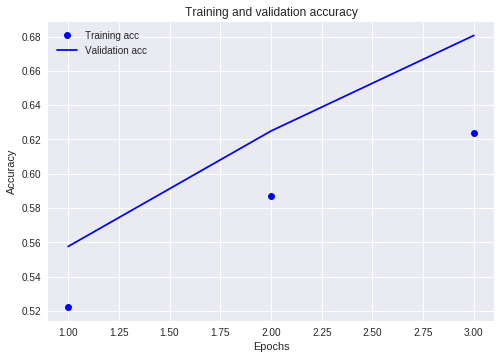

In [0]:
import matplotlib.pyplot as plt

history_dict_lstm3 = history_lstm3.history

acc = history_dict_lstm3['acc']
val_acc = history_dict_lstm3['val_acc']
loss = history_dict_lstm3['loss']
val_loss = history_dict_lstm3['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
from keras import optimizers
ad= optimizers.adam(lr=0.01)

model_lstm4 = Sequential() 

model_lstm4.add(embedding_layer)
model_lstm4.add(Dropout(0.5))
#model_lstm.add(GlobalAveragePooling1DMasked())

model_lstm4.add(LSTM(100)) 
model_lstm4.add(Dropout(0.5))
model_lstm4.add(Dense(3, activation='sigmoid')) 

model_lstm4.compile(loss='categorical_crossentropy',optimizer=ad,  metrics=['accuracy']) 

model_lstm4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 144, 300)          11108700  
_________________________________________________________________
dropout_11 (Dropout)         (None, 144, 300)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 303       
Total params: 11,269,403
Trainable params: 160,703
Non-trainable params: 11,108,700
_________________________________________________________________


In [0]:
history_lstm4 = model_lstm4.fit(x_train,
                    y_train,
                    epochs=6,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 16505 samples, validate on 4127 samples
Epoch 1/6
16505/16505 [==============================] - 99s 6ms/step - loss: 0.9444 - acc: 0.5387 - val_loss: 0.8327 - val_acc: 0.6147
Epoch 2/6
16505/16505 [==============================] - 95s 6ms/step - loss: 0.8402 - acc: 0.6005 - val_loss: 0.7461 - val_acc: 0.6542
Epoch 3/6
16505/16505 [==============================] - 95s 6ms/step - loss: 0.7948 - acc: 0.6323 - val_loss: 0.7214 - val_acc: 0.6729
Epoch 4/6
16505/16505 [==============================] - 96s 6ms/step - loss: 0.7735 - acc: 0.6476 - val_loss: 0.7087 - val_acc: 0.6850
Epoch 5/6
16505/16505 [==============================] - 95s 6ms/step - loss: 0.7582 - acc: 0.6556 - val_loss: 0.6840 - val_acc: 0.6913
Epoch 6/6
16505/16505 [==============================] - 95s 6ms/step - loss: 0.7303 - acc: 0.6648 - val_loss: 0.6928 - val_acc: 0.6826


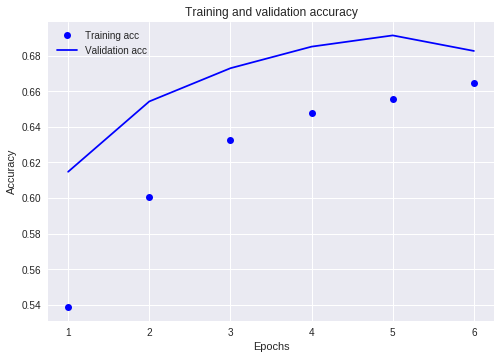

In [0]:
import matplotlib.pyplot as plt

history_dict_lstm4 = history_lstm4.history

acc = history_dict_lstm4['acc']
val_acc = history_dict_lstm4['val_acc']
loss = history_dict_lstm4['loss']
val_loss = history_dict_lstm4['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
from keras import optimizers
from keras.layers import Activation
ad= optimizers.adam(lr=0.01)


model_lstm6 = Sequential() 

model_lstm6.add(embedding_layer)
model_lstm6.add(Dropout(0.5))
#model_lstm.add(GlobalAveragePooling1DMasked())

model_lstm6.add(LSTM(100,activation='tanh')) 
model_lstm6.add(Dropout(0.5))
model_lstm6.add(Dense(3, activation='sigmoid')) 

model_lstm6.compile(loss='categorical_crossentropy',optimizer=ad,  metrics=['accuracy']) 

model_lstm6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 144, 300)          11108700  
_________________________________________________________________
dropout_19 (Dropout)         (None, 144, 300)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dropout_20 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 303       
Total params: 11,269,403
Trainable params: 160,703
Non-trainable params: 11,108,700
_________________________________________________________________


In [0]:
history_lstm6 = model_lstm6.fit(x_train,
                    y_train,
                    epochs=6,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 16505 samples, validate on 4127 samples
Epoch 1/6
16505/16505 [==============================] - 96s 6ms/step - loss: 0.9347 - acc: 0.5361 - val_loss: 0.7655 - val_acc: 0.6504
Epoch 2/6
16505/16505 [==============================] - 95s 6ms/step - loss: 0.8400 - acc: 0.6068 - val_loss: 0.7334 - val_acc: 0.6731
Epoch 3/6
16505/16505 [==============================] - 94s 6ms/step - loss: 0.7891 - acc: 0.6353 - val_loss: 0.7347 - val_acc: 0.6729
Epoch 4/6
16505/16505 [==============================] - 94s 6ms/step - loss: 0.7642 - acc: 0.6499 - val_loss: 0.6865 - val_acc: 0.6964
Epoch 5/6
16505/16505 [==============================] - 94s 6ms/step - loss: 0.7528 - acc: 0.6582 - val_loss: 0.6780 - val_acc: 0.6993
Epoch 6/6
16505/16505 [==============================] - 94s 6ms/step - loss: 0.7296 - acc: 0.6710 - val_loss: 0.6875 - val_acc: 0.6942


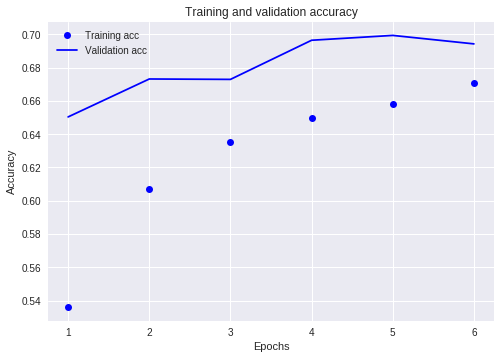

In [0]:
import matplotlib.pyplot as plt

history_dict_lstm6 = history_lstm6.history

acc = history_dict_lstm6['acc']
val_acc = history_dict_lstm6['val_acc']
loss = history_dict_lstm6['loss']
val_loss = history_dict_lstm6['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
from keras import optimizers
from keras.layers import Activation
ad= optimizers.adam(lr=0.01)


model_lstm7 = Sequential() 

model_lstm7.add(embedding_layer)
model_lstm7.add(Dropout(0.5))
#model_lstm.add(GlobalAveragePooling1DMasked())

model_lstm7.add(LSTM(100,activation='tanh')) 

model_lstm7.add(Dropout(0.5))
model_lstm7.add(Dense(3, activation='softmax')) 

model_lstm7.compile(loss='categorical_crossentropy',optimizer=ad,  metrics=['accuracy']) 

model_lstm7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 144, 300)          11108700  
_________________________________________________________________
dropout_25 (Dropout)         (None, 144, 300)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dropout_26 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 303       
Total params: 11,269,403
Trainable params: 160,703
Non-trainable params: 11,108,700
_________________________________________________________________


In [0]:
history_lstm7 = model_lstm7.fit(x_train,
                    y_train,
                    epochs=6,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 16505 samples, validate on 4127 samples
Epoch 1/6
16505/16505 [==============================] - 99s 6ms/step - loss: 0.9234 - acc: 0.5498 - val_loss: 0.7827 - val_acc: 0.6513
Epoch 2/6
16505/16505 [==============================] - 98s 6ms/step - loss: 0.8365 - acc: 0.6065 - val_loss: 0.7249 - val_acc: 0.6768
Epoch 3/6
16505/16505 [==============================] - 96s 6ms/step - loss: 0.7933 - acc: 0.6353 - val_loss: 0.7138 - val_acc: 0.6780
Epoch 4/6
16505/16505 [==============================] - 96s 6ms/step - loss: 0.7747 - acc: 0.6431 - val_loss: 0.7031 - val_acc: 0.6814
Epoch 5/6
16505/16505 [==============================] - 97s 6ms/step - loss: 0.7568 - acc: 0.6544 - val_loss: 0.6939 - val_acc: 0.6942
Epoch 6/6
16505/16505 [==============================] - 96s 6ms/step - loss: 0.7330 - acc: 0.6694 - val_loss: 0.7102 - val_acc: 0.6693


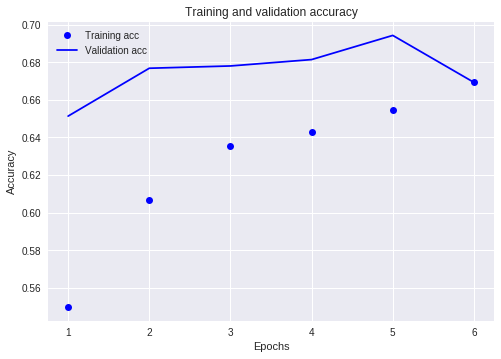

In [0]:
import matplotlib.pyplot as plt

history_dict_lstm7 = history_lstm7.history

acc = history_dict_lstm7['acc']
val_acc = history_dict_lstm7['val_acc']
loss = history_dict_lstm7['loss']
val_loss = history_dict_lstm7['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
model_lstm8 = Sequential() 

model_lstm8.add(embedding_layer)
model_lstm8.add(Dropout(0.3))

model_lstm8.add(LSTM(100)) 
model_lstm8.add(Dropout(0.3))
model_lstm8.add(Dense(3, activation='softmax')) 
model_lstm8.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) 

model_lstm8.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 144, 300)          11108700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 11,269,403
Trainable params: 160,703
Non-trainable params: 11,108,700
___

In [0]:
history_lstm8 = model_lstm8.fit(x_train,
                    y_train,
                    epochs=6,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 16505 samples, validate on 4127 samples
Epoch 1/6
16505/16505 [==============================] - 103s 6ms/step - loss: 0.9355 - acc: 0.5400 - val_loss: 0.8966 - val_acc: 0.5580
Epoch 2/6
16505/16505 [==============================] - 103s 6ms/step - loss: 0.8494 - acc: 0.5965 - val_loss: 0.7803 - val_acc: 0.6474
Epoch 3/6
16505/16505 [==============================] - 102s 6ms/step - loss: 0.8238 - acc: 0.6099 - val_loss: 0.7534 - val_acc: 0.6639
Epoch 4/6
16505/16505 [==============================] - 103s 6ms/step - loss: 0.8073 - acc: 0.6213 - val_loss: 0.7356 - val_acc: 0.6719
Epoch 5/6
16505/16505 [==============================] - 102s 6ms/step - loss: 0.7875 - acc: 0.6335 - val_loss: 0.7279 - val_acc: 0.6668
Epoch 6/6
16505/16505 [==============================] - 102s 6ms/step - loss: 0.7817 - acc: 0.6404 - val_loss: 0.7323 - val_acc: 0.6702


In [0]:
results_lstm8 = model_lstm8.evaluate(x_val,y_val)
print('Test Loss: ', results_lstm8[0], 'Test Accuracy: ',results_lstm8[1])

4127/4127 [==============================] - 12s 3ms/step
Test Loss:  0.7323334260832637 Test Accuracy:  0.6702204989930577


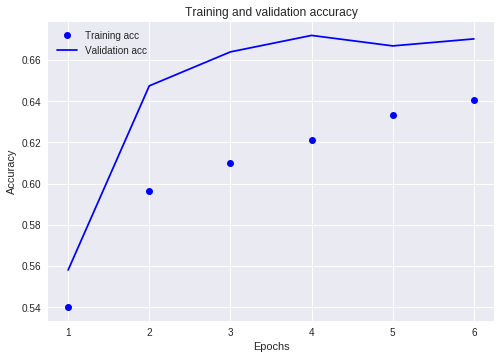

In [0]:
import matplotlib.pyplot as plt

history_dict_lstm8 = history_lstm8.history

acc = history_dict_lstm8['acc']
val_acc = history_dict_lstm8['val_acc']
loss = history_dict_lstm8['loss']
val_loss = history_dict_lstm8['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
model_lstm9 = Sequential() 

model_lstm9.add(embedding_layer)
model_lstm9.add(Dropout(0.3))

model_lstm9.add(LSTM(100,activation='tanh')) 
model_lstm9.add(Dropout(0.3))
model_lstm9.add(Dense(3, activation='softmax')) 
model_lstm9.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) 

model_lstm9.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 144, 300)          11108700  
_________________________________________________________________
dropout_3 (Dropout)          (None, 144, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 11,269,403
Trainable params: 160,703
Non-trainable params: 11,108,700
_________________________________________________________________


In [0]:
history_lstm9 = model_lstm9.fit(x_train,
                    y_train,
                    epochs=6,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 16505 samples, validate on 4127 samples
Epoch 1/6
16505/16505 [==============================] - 103s 6ms/step - loss: 0.9365 - acc: 0.5493 - val_loss: 0.8518 - val_acc: 0.5869
Epoch 2/6
16505/16505 [==============================] - 102s 6ms/step - loss: 0.8528 - acc: 0.5930 - val_loss: 0.7850 - val_acc: 0.6295
Epoch 3/6
16505/16505 [==============================] - 103s 6ms/step - loss: 0.8264 - acc: 0.6077 - val_loss: 0.7438 - val_acc: 0.6663
Epoch 4/6
16505/16505 [==============================] - 102s 6ms/step - loss: 0.8022 - acc: 0.6254 - val_loss: 0.7399 - val_acc: 0.6726
Epoch 5/6
16505/16505 [==============================] - 102s 6ms/step - loss: 0.7931 - acc: 0.6325 - val_loss: 0.7201 - val_acc: 0.6768
Epoch 6/6
16505/16505 [==============================] - 103s 6ms/step - loss: 0.7745 - acc: 0.6454 - val_loss: 0.7373 - val_acc: 0.6637
